In [1]:
import torch as th
import numpy as np
import pickle
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np
from pytorch_lightning import seed_everything
import torch as th
import os
import sys
import glob
sys.path.insert(0, '../../sample_scripts/')

from sample_scripts.sample_utils.inference_utils import to_tensor
from sample_scripts.sample_utils.vis_utils import plot_image
from sample_scripts.sample_utils import (
    ckpt_utils, 
    file_utils,
    params_utils,
)
from guided_diffusion.dataloader.img_deca_datasets import load_data_img_deca

device = 'cuda:1'

plt.rcParams["savefig.bbox"] = 'tight'
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
def get_cfg(self):
    from config.base_config import parse_args
    cfg_file_path = glob.glob("/home/mint/guided-diffusion/config/*/*", recursive=True)
    cfg_file_path = [cfg_path for cfg_path in cfg_file_path if f"/{self.cfg_name}" in cfg_path]    # Add /{}/ to achieve a case-sensitive of folder
    print("[#] Config Path : ", cfg_file_path)
    assert len(cfg_file_path) <= 1
    assert len(cfg_file_path) > 0
    cfg_file = cfg_file_path[0]
    cfg = parse_args(ipynb={'mode':True, 'cfg':cfg_file})
    return cfg

In [2]:
ckpt_loader = ckpt_utils.CkptLoader(log_dir="UNetCond_Spatial_Hadamart_Tanh_Shape", cfg_name="UNetCond_Spatial_Hadamart_Tanh_Shape.yaml")
cfg = ckpt_loader.cfg
cfg.img_cond_model.in_image = cfg.img_cond_model.in_image + ['faceseg_bg_noface&nohair']
cfg.img_cond_model.prep_image = [None, None]
# Load dataset
img_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/"
deca_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/params/"

loader, dataset, _ = load_data_img_deca(
    data_dir=img_dataset_path,
    deca_dir=deca_dataset_path,
    batch_size=int(1e7),
    image_size=cfg.img_model.image_size,
    deterministic=cfg.train.deterministic,
    augment_mode=cfg.img_model.augment_mode,
    resize_mode=cfg.img_model.resize_mode,
    in_image_UNet=cfg.img_model.in_image,
    params_selector=cfg.param_model.params_selector + ['albedo'],
    rmv_params=cfg.param_model.rmv_params,
    set_='valid',
    cfg=cfg,
)

# _, _, avg_dict = load_data_img_deca(
#     data_dir=img_dataset_path,
#     deca_dir=deca_dataset_path,
#     batch_size=int(1e7),
#     image_size=cfg.img_model.image_size,
#     deterministic=cfg.train.deterministic,
#     augment_mode=cfg.img_model.augment_mode,
#     resize_mode=cfg.img_model.resize_mode,
#     in_image_UNet=cfg.img_model.in_image,
#     params_selector=cfg.param_model.params_selector + ['albedo'],
#     rmv_params=cfg.param_model.rmv_params,
#     set_='train',
#     cfg=cfg,
# )

img_path = file_utils._list_image_files_recursively(f"{img_dataset_path}/valid/")
img_idx = file_utils.search_index_from_listpath(list_path=img_path, search=['60065.jpg', '60182.jpg'])
dat = th.utils.data.Subset(dataset, indices=img_idx)
subset_loader = th.utils.data.DataLoader(dat, batch_size=2,
                                    shuffle=False, num_workers=24)
                            
dat, model_kwargs = next(iter(subset_loader))

[#] Model Path :  ['/data/mint/model_logs_mount/v12/UNetCond_Spatial_Hadamart_Tanh_Shape/']
[#] Config Path :  ['/home/mint/guided-diffusion/config/EncLight_Spatial_Rendered_Face_Hadamart_clip/UNetCond_Spatial_Hadamart_Tanh_Shape.yaml']
Merging with :  Namespace(cfg='/home/mint/guided-diffusion/config/EncLight_Spatial_Rendered_Face_Hadamart_clip/UNetCond_Spatial_Hadamart_Tanh_Shape.yaml')



Loading deca params...: 100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


[#] Parameters Conditioning
Params keys order :  ['shape', 'pose', 'exp', 'cam', 'faceemb']
Remove keys :  []


creating the FLAME Decoder
trained model found. load /home/mint/guided-diffusion/sample_scripts/cond_utils/DECA/data/deca_model.tar
[#] DECA : SRenderY applied mask


/home/mint/guided-diffusion/sample_scripts/sample_utils/params_utils.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'light':th.tensor(deca_params['light']).to(device).reshape(-1, 9, 3).float(),
/home/mint/miniconda3/envs/3dr_sampling_deca/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


torch.Size([2, 10750, 3, 3]) torch.Size([2, 10750, 3, 3]) torch.Size([2, 10750, 3, 3]) torch.Size([2, 10750, 3, 3]) torch.Size([1, 10750, 3, 3])
torch.Size([2, 10750, 3, 3]) torch.Size([2, 10750, 3, 3]) torch.Size([2, 10750, 3, 3]) torch.Size([2, 10750, 3, 3]) torch.Size([1, 10750, 3, 3])


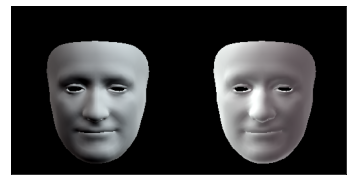

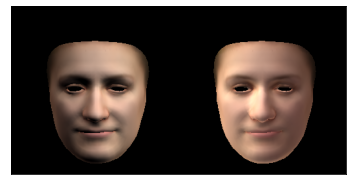

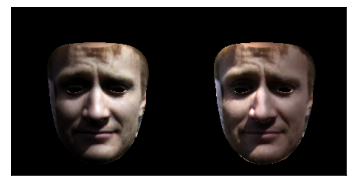

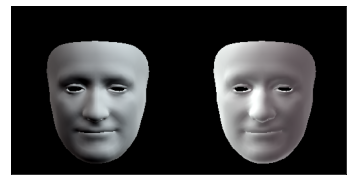

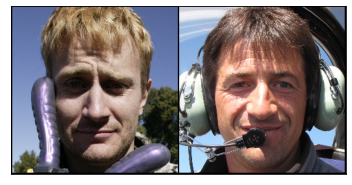

In [5]:
from importlib import reload
reload(params_utils)

f_mask = np.load('./FLAME_masks_face-id.pkl', allow_pickle=True, encoding='latin1')
v_mask = np.load('./FLAME_masks.pkl', allow_pickle=True, encoding='latin1')
mask={
    'v_mask':v_mask['face'].tolist(),
    'f_mask':f_mask['face'].tolist()
}        
# rendered_image, orig_visdict = params_utils.render_deca(deca_params=model_kwargs, idx=0, n=2, deca_mode='only_renderer', mask=mask)
rendered_image, orig_visdict = params_utils.render_deca(deca_params=model_kwargs, idx=0, n=2, useTex=True, extractTex=True, deca_mode='', use_detail=True, mask=mask)

grid = torchvision.utils.make_grid(orig_visdict['shape_images'].mul(255).add_(0.5).clamp_(0, 255).cpu())
show(grid/255.0)
grid = torchvision.utils.make_grid(orig_visdict['rendered_images'].mul(255).add_(0.5).clamp_(0, 255).cpu())
show(grid/255.0)

grid = torchvision.utils.make_grid(orig_visdict['rendered_images_uv_texture'].mul(255).add_(0.5).clamp_(0, 255).cpu())
show(grid/255.0)

grid = torchvision.utils.make_grid(orig_visdict['shape_images'].mul(255).add_(0.5).clamp_(0, 255).cpu())
show(grid/255.0)

grid = torchvision.utils.make_grid(model_kwargs['raw_image'].cpu())
show(grid/255.0)


# Create the masking faces indices 

In [ ]:
from model_3d.FLAME.config import cfg as flame_cfg
import model_3d.FLAME.FLAME as FLAME
import model_3d.FLAME.utils.renderer as renderer_lib
import model_3d.FLAME.utils.util as util
from importlib import reload
import numpy as np
reload(renderer_lib)
reload(FLAME)

flame = FLAME.FLAME(flame_cfg.model).cuda()
renderer = renderer_lib.SRenderY(image_size=256, obj_filename=flame_cfg.model.topology_path, uv_size=flame_cfg.model.uv_size).cuda()
print(renderer.faces.shape)
print(renderer.face_colors.shape)


def index_masking_faces(mask, faces):
    print("[#] Create indexing masked of faces...")
    import tqdm, pickle
    rm_faces = {}
    for k in mask.keys():
        rm_faces[k] = []
        print("Processing : ", k)
        for m in tqdm.tqdm(mask[k].tolist()):
            for i, f in enumerate(faces[0]):
                if m in f:
                    rm_faces[k].append(i)
        rm_faces[k] = np.array(rm_faces[k])
    
    with open('FLAME_masks_face-id.pkl', 'wb') as output:
        pickle.dump(rm_faces, output)

mask = np.load('./FLAME_masks.pkl', allow_pickle=True, encoding='latin1')
count = 0
mask_list = []
for k, v in mask.items():
    count += len(v)
    print(f"{k} - {v.shape}")
    mask_list.append(v)
mask_list = np.concatenate(mask_list, -1)

print(renderer.faces.shape)
print(type(mask['face'][0]))
print("#"*50)
index_masking_faces(mask, renderer.faces)